In [1]:
import numpy as np

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

import pandas as pd

from scipy.optimize import  curve_fit
from sklearn.metrics import r2_score

In [2]:
ar_dados=pd.read_excel('ar.xlsx')
agua_dados=pd.read_excel('agua.xlsx')

In [3]:
a= 5

def normalizar(t_data, y_data):
    y_data  = np.array(y_data)
    y_m = y_data.mean()

    return t_data, (y_data - y_m)

def derivar(t_data, y_data):
    tamanho = len(t_data)
    t2_data = t_data[a:-a]
    dydx_data = []   #começa um ponto depois e acaba um ponto antes

    for i in range(a, tamanho-a):
        derivada = (y_data[i + a] - y_data[i-a])/(t_data[i+a] - t_data[i-a])
        dydx_data.append(derivada)

    return t2_data, dydx_data

def maximos_minimos (t2_data, dydx_data, t_data, y_data):
    t_maximos = []
    t_minimos = []

    y_maximos = []
    y_minimos = []

    skip = 100  #frames
    cont = 0
    achou = False

    for i in range(1, len(t2_data)-1):
        if achou:
            if cont == skip:
                pass
            else:
                cont += 1
                continue

        cont = 0
        achou = False

        if dydx_data[i+1] >= 0 and dydx_data[i]<=0:
            t_minimos.append(t2_data[i])
            y_minimos.append(y_data[i + a])
            achou = True
        if dydx_data[i+1] <= 0 and dydx_data[i]>=0:
            t_maximos.append(t2_data[i])
            y_maximos.append(y_data[i + a])
            achou = True

    return t_maximos, t_minimos, y_maximos, y_minimos

def achar_omega(t_maximos, t_minimos):
    T = np.array([])
    for i in range(len(t_maximos)-1):
        delta_t = t_maximos[i+1] - t_maximos[i]
        T = np.append(T, np.array([delta_t]))
    for i in range(len(t_minimos)-1):
        delta_t = t_minimos[i+1] - t_minimos[i]
        T = np.append(T, np.array([delta_t]))

    omega = 2*np.pi/T
    return T, omega.mean(), omega.std(ddof=1)

def achar_gamma(t_maximos, t_minimos, y_maximos, y_minimos):
    if t_maximos[0] < t_minimos[0]:
        amplitudes = np.append(np.abs(np.array(y_maximos)), np.abs(np.array(y_minimos)))
        tempos = np.append(np.array(t_maximos), np.array(t_minimos))
    else:
        amplitudes = np.append(np.abs(np.array(y_minimos)), np.abs(np.array(y_maximos)))
        tempos = np.append(np.array(t_minimos), np.array(t_maximos))

    tempos= tempos - tempos[0]
    print("Tempos")
    print(tempos)
    print("Amplitudes")
    print(amplitudes)

    print("Amplitudes normalizadas")
    amplitudes = amplitudes/amplitudes[0]
    print(amplitudes)

    print("Erro amplitudes normalizadas")
    amplitudes_err = 1/amplitudes[0] *0.001 + amplitudes/(amplitudes[0]**2)*0.001
    print(amplitudes_err)


    popt, pcov = curve_fit(lambda t, gamma: np.exp(-gamma*t), tempos, amplitudes)
    gamma = popt[0]
    gamma_err = pcov[0][0]
    r2 = r2_score(amplitudes,np.exp(-gamma*tempos) )

    print("O valor de gamma é: " + str(gamma) + " +- " + str(gamma_err))

    t = np.linspace(np.min(tempos), np.max(tempos), 200)
    y = np.exp(-gamma*t)

    plt.clf()
    plt.scatter(tempos, amplitudes, s = 5, color = 'blue', label = "Pontos Experimentais")
    plt.plot(t, y, color ='red', label = f'Fit: $exp(- \gamma t)$ , $r^2 = {r2:.4f} $')

    plt.title("Amplitude Normalizada X Tempo")
    plt.ylabel(f"$|x_i/x_0|$")
    plt.xlabel(f"t(s)")
    plt.legend()
    plt.yscale('log')
        

In [4]:
def main(t_data, y_data, gamma = False):
    t_data, y_data = normalizar(t_data, y_data)

    t2_data, dydx_data = derivar(t_data, y_data)
    t_maximos, t_minimos, y_maximos, y_minimos = maximos_minimos(t2_data, dydx_data, t_data, y_data)
    T, omega, omega_err = achar_omega(t_maximos, t_minimos)

    if gamma:
        achar_gamma( t_maximos, t_minimos, y_maximos, y_minimos)
    else:
        print("O valor de omega é: " + str(omega)+ " +- " + str(omega_err))
        print("")
        print("Os valores de períodos medidos foram: ")
        display(T)
        print("")

        plt.scatter(t_data, y_data,marker='o', s= 2)
        plt.scatter(t_maximos, y_maximos, color = 'red')
        plt.scatter(t_minimos, y_minimos, color = 'green')

    

O valor de omega é: 4.159040222679205 +- 0.021420844931404694

Os valores de períodos medidos foram: 


array([1.512542, 1.516638, 1.508276, 1.508413, 1.516624, 1.504183,
       1.49995 , 1.512467, 1.521249, 1.495453, 1.516647, 1.516753])

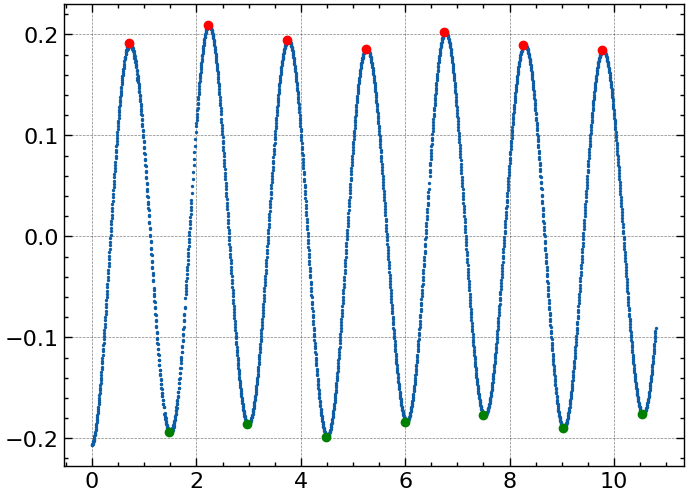

In [5]:
t_data =  ar_dados['t']
y_data =  ar_dados['y']

main(t_data, y_data)

Tempos
[0.       1.512542 3.02918  4.537456 6.045869 7.562493 9.066676 0.766701
 2.266651 3.779118 5.300367 6.79582  8.312467 9.82922 ]
Amplitudes
[0.19168851 0.20906731 0.19401111 0.18545021 0.20241541 0.18972021
 0.18423041 0.19334209 0.18565628 0.19879858 0.18343125 0.17728058
 0.18983457 0.17566124]
Amplitudes normalizadas
[1.         1.09066167 1.01211653 0.96745606 1.05596006 0.98973178
 0.96109261 1.00862642 0.96853111 1.03709183 0.95692358 0.92483679
 0.9903284  0.91638902]
O valor de gamma é: 0.0035132560657876533 +- 4.430687282229981e-06


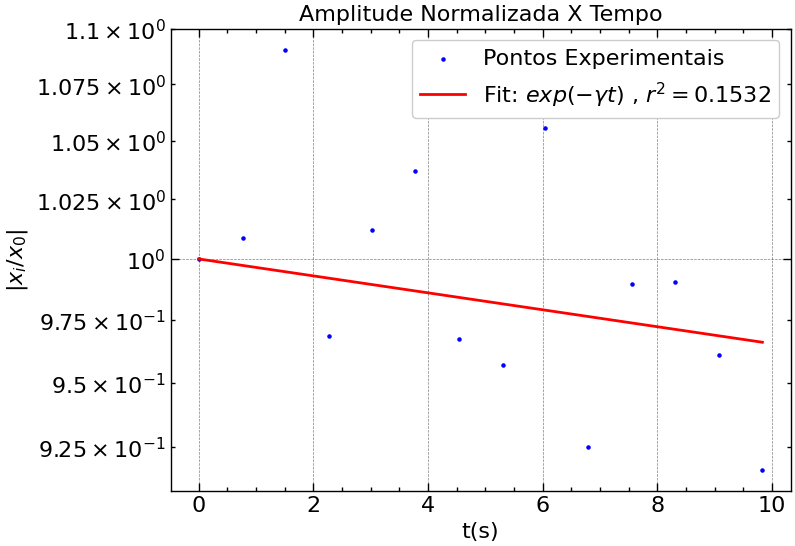

In [6]:
main(t_data, y_data, gamma = True)

O valor de omega é: 4.109125030473428 +- 0.1392227944393166

Os valores de períodos medidos foram: 


array([1.50414 , 1.545889, 1.462418, 1.545847, 1.6     , 1.543358,
       1.510793, 1.554231, 1.508261, 1.445887, 1.616601])

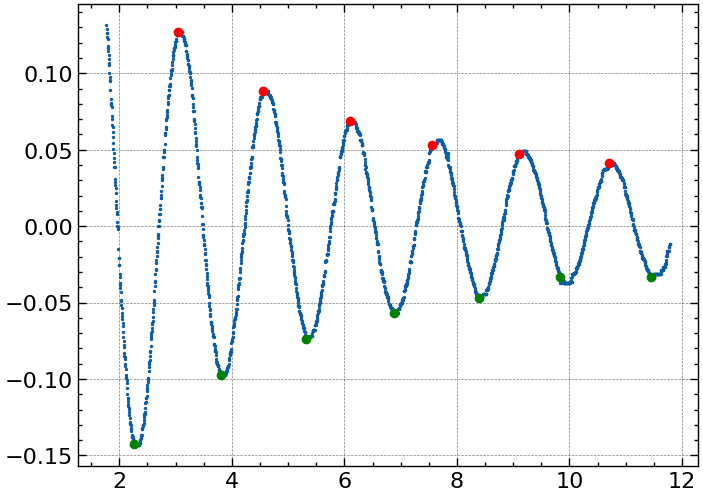

In [7]:
t_data =  agua_dados['t']
y_data =  agua_dados['y']

main(t_data, y_data)

Tempos
[0.       1.543358 3.054151 4.608382 6.116643 7.56253  9.179131 0.779167
 2.283307 3.829196 5.291614 6.837461 8.437461]
Amplitudes
[0.14251567 0.09749297 0.07367747 0.05700987 0.04706967 0.03313747
 0.03343287 0.1272879  0.08829894 0.06879402 0.05281404 0.04701991
 0.04143597]
Amplitudes normalizadas
[1.         0.68408596 0.51697802 0.40002526 0.33027714 0.23251806
 0.23459082 0.89315023 0.61957359 0.482712   0.37058412 0.32992803
 0.29074679]
O valor de gamma é: 0.18419480404439761 +- 5.063645929311452e-05


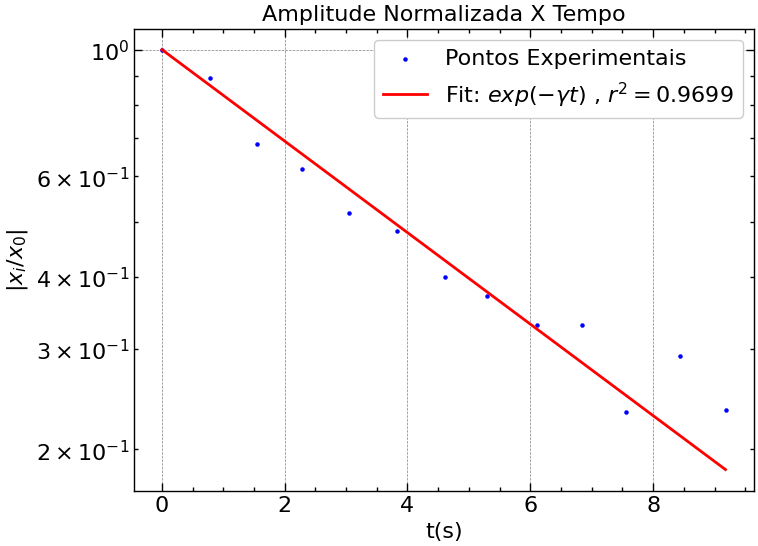

In [8]:
main(t_data, y_data, gamma = True)

In [9]:
np.sqrt(4.159040222679205**2 - 0.18419480404439761**2)

4.154959427963953